# The notebook contains
### Code for _Bulyan_ aggregation algorithm, *when gradient updates of benign clients are unknown to adversary*
### Evaluation of all of the attacks (Fang, LIE, and our SOTA AGR-tailored and AGR-agnstic) on Bulyan

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from __future__ import print_function
import argparse, os, sys, csv, shutil, time, random, operator, pickle, ast, math
import numpy as np
import pandas as pd
from torch.optim import Optimizer
import torch.nn.functional as F
import torch
import pickle
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torch.multiprocessing as mp

sys.path.insert(0,'./../utils/')
from logger import *
from eval import *
from misc import *

from cifar10_normal_train import *
from cifar10_util import *
from adam import Adam
from sgd import SGD

## Get cifar10 data and split it in IID fashion

In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
data_loc='/mnt/nfs/work1/amir/vshejwalkar/cifar10_data/'
# load the train dataset

train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

cifar10_train = datasets.CIFAR10(root=data_loc, train=True, download=True, transform=train_transform)

cifar10_test = datasets.CIFAR10(root=data_loc, train=False, download=True, transform=train_transform)

X=[]
Y=[]
for i in range(len(cifar10_train)):
    X.append(cifar10_train[i][0].numpy())
    Y.append(cifar10_train[i][1])

for i in range(len(cifar10_test)):
    X.append(cifar10_test[i][0].numpy())
    Y.append(cifar10_test[i][1])

X=np.array(X)
Y=np.array(Y)

print('total data len: ',len(X))

if not os.path.isfile('./cifar10_shuffle.pkl'):
    all_indices = np.arange(len(X))
    np.random.shuffle(all_indices)
    pickle.dump(all_indices,open('./cifar10_shuffle.pkl','wb'))
else:
    all_indices=pickle.load(open('./cifar10_shuffle.pkl','rb'))

X=X[all_indices]
Y=Y[all_indices]

Files already downloaded and verified
Files already downloaded and verified
total data len:  60000


## Divide cifar10 data among 50 clients in IID fashion

In [4]:
# data loading

nusers=50
user_tr_len=1000

total_tr_len=user_tr_len*nusers
val_len=5000
te_len=5000

print('total data len: ',len(X))

if not os.path.isfile('./cifar10_shuffle.pkl'):
    all_indices = np.arange(len(X))
    np.random.shuffle(all_indices)
    pickle.dump(all_indices,open('./cifar10_shuffle.pkl','wb'))
else:
    all_indices=pickle.load(open('./cifar10_shuffle.pkl','rb'))

total_tr_data=X[:total_tr_len]
total_tr_label=Y[:total_tr_len]

val_data=X[total_tr_len:(total_tr_len+val_len)]
val_label=Y[total_tr_len:(total_tr_len+val_len)]

te_data=X[(total_tr_len+val_len):(total_tr_len+val_len+te_len)]
te_label=Y[(total_tr_len+val_len):(total_tr_len+val_len+te_len)]

total_tr_data_tensor=torch.from_numpy(total_tr_data).type(torch.FloatTensor)
total_tr_label_tensor=torch.from_numpy(total_tr_label).type(torch.LongTensor)

val_data_tensor=torch.from_numpy(val_data).type(torch.FloatTensor)
val_label_tensor=torch.from_numpy(val_label).type(torch.LongTensor)

te_data_tensor=torch.from_numpy(te_data).type(torch.FloatTensor)
te_label_tensor=torch.from_numpy(te_label).type(torch.LongTensor)

print('total tr len %d | val len %d | test len %d'%(len(total_tr_data_tensor),len(val_data_tensor),len(te_data_tensor)))

#==============================================================================================================

user_tr_data_tensors=[]
user_tr_label_tensors=[]

for i in range(nusers):
    
    user_tr_data_tensor=torch.from_numpy(total_tr_data[user_tr_len*i:user_tr_len*(i+1)]).type(torch.FloatTensor)
    user_tr_label_tensor=torch.from_numpy(total_tr_label[user_tr_len*i:user_tr_len*(i+1)]).type(torch.LongTensor)

    user_tr_data_tensors.append(user_tr_data_tensor)
    user_tr_label_tensors.append(user_tr_label_tensor)
    print('user %d tr len %d'%(i,len(user_tr_data_tensor)))

total data len:  60000
total tr len 50000 | val len 5000 | test len 5000
user 0 tr len 1000
user 1 tr len 1000
user 2 tr len 1000
user 3 tr len 1000
user 4 tr len 1000
user 5 tr len 1000
user 6 tr len 1000
user 7 tr len 1000
user 8 tr len 1000
user 9 tr len 1000
user 10 tr len 1000
user 11 tr len 1000
user 12 tr len 1000
user 13 tr len 1000
user 14 tr len 1000
user 15 tr len 1000
user 16 tr len 1000
user 17 tr len 1000
user 18 tr len 1000
user 19 tr len 1000
user 20 tr len 1000
user 21 tr len 1000
user 22 tr len 1000
user 23 tr len 1000
user 24 tr len 1000
user 25 tr len 1000
user 26 tr len 1000
user 27 tr len 1000
user 28 tr len 1000
user 29 tr len 1000
user 30 tr len 1000
user 31 tr len 1000
user 32 tr len 1000
user 33 tr len 1000
user 34 tr len 1000
user 35 tr len 1000
user 36 tr len 1000
user 37 tr len 1000
user 38 tr len 1000
user 39 tr len 1000
user 40 tr len 1000
user 41 tr len 1000
user 42 tr len 1000
user 43 tr len 1000
user 44 tr len 1000
user 45 tr len 1000
user 46 tr len 10

## Code for Multi-krum aggregation algorithm

In [5]:
def multi_krum(all_updates, n_attackers, multi_k=False):

    candidates = []
    candidate_indices = []
    remaining_updates = all_updates
    all_indices = np.arange(len(all_updates))

    while len(remaining_updates) > 2 * n_attackers + 2:
        torch.cuda.empty_cache()
        distances = []
        for update in remaining_updates:
            distance = []
            for update_ in remaining_updates:
                distance.append(torch.norm((update - update_)) ** 2)
            distance = torch.Tensor(distance).float()
            distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)

        distances = torch.sort(distances, dim=1)[0]
        scores = torch.sum(distances[:, :len(remaining_updates) - 2 - n_attackers], dim=1)
        indices = torch.argsort(scores)[:len(remaining_updates) - 2 - n_attackers]

        candidate_indices.append(all_indices[indices[0].cpu().numpy()])
        all_indices = np.delete(all_indices, indices[0].cpu().numpy())
        candidates = remaining_updates[indices[0]][None, :] if not len(candidates) else torch.cat((candidates, remaining_updates[indices[0]][None, :]), 0)
        remaining_updates = torch.cat((remaining_updates[:indices[0]], remaining_updates[indices[0] + 1:]), 0)
        if not multi_k:
            break
    # print(len(remaining_updates))

    aggregate = torch.mean(candidates, dim=0)

    return aggregate, np.array(candidate_indices)

## Code for Bulyan aggregation algorithm

In [6]:
def bulyan(all_updates, n_attackers):
    nusers = all_updates.shape[0]
    bulyan_cluster = []
    candidate_indices = []
    remaining_updates = all_updates
    all_indices = np.arange(len(all_updates))

    while len(bulyan_cluster) < (nusers - 2 * n_attackers):
        torch.cuda.empty_cache()
        distances = []
        for update in remaining_updates:
            distance = []
            for update_ in remaining_updates:
                distance.append(torch.norm((update - update_)) ** 2)
            distance = torch.Tensor(distance).float()
            distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)
        # print(distances)

        distances = torch.sort(distances, dim=1)[0]

        scores = torch.sum(distances[:, :len(remaining_updates) - 2 - n_attackers], dim=1)
        indices = torch.argsort(scores)[:len(remaining_updates) - 2 - n_attackers]
        if not len(indices):
            break
        candidate_indices.append(all_indices[indices[0].cpu().numpy()])
        all_indices = np.delete(all_indices, indices[0].cpu().numpy())
        bulyan_cluster = remaining_updates[indices[0]][None, :] if not len(bulyan_cluster) else torch.cat((bulyan_cluster, remaining_updates[indices[0]][None, :]), 0)
        remaining_updates = torch.cat((remaining_updates[:indices[0]], remaining_updates[indices[0] + 1:]), 0)

    # print('dim of bulyan cluster ', bulyan_cluster.shape)

    n, d = bulyan_cluster.shape
    param_med = torch.median(bulyan_cluster, dim=0)[0]
    sort_idx = torch.argsort(torch.abs(bulyan_cluster - param_med), dim=0)
    sorted_params = bulyan_cluster[sort_idx, torch.arange(d)[None, :]]

    return torch.mean(sorted_params[:n - 2 * n_attackers], dim=0), np.array(candidate_indices)

## Code for fang attack on Bulyan
### Note that Fang attacks on Multi-krum and Bulyan are the same

In [11]:
def compute_lambda_fang(all_updates, model_re, n_attackers):

    distances = []
    n_benign, d = all_updates.shape
    for update in all_updates:
        distance = torch.norm((all_updates - update), dim=1)
        distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)

    distances[distances == 0] = 10000
    distances = torch.sort(distances, dim=1)[0]
    scores = torch.sum(distances[:, :n_benign - 2 - n_attackers], dim=1)
    min_score = torch.min(scores)
    term_1 = min_score / ((n_benign - n_attackers - 1) * torch.sqrt(torch.Tensor([d]))[0])
    max_wre_dist = torch.max(torch.norm((all_updates - model_re), dim=1)) / (torch.sqrt(torch.Tensor([d]))[0])
    # print(term_1 + max_wre_dist) # tensor(0.0001, device='cuda:0')
    return (term_1 + max_wre_dist)


def get_malicious_updates_fang(all_updates, model_re, deviation, n_attackers):
    # deviation = torch.sign(agg_grads)
    # print("all_updates.shape ", all_updates.shape) # all_updates.shape  torch.Size([10, 2472266])
    # print("n_attackers ", n_attackers) # n_attackers  2
    # print("model_re.shape ", model_re.shape) # model_re.shape torch.Size([2472266])
    
    lamda = compute_lambda_fang(all_updates, model_re, n_attackers) # tensor(0.0001, device='cuda:0')
    
    threshold = 1e-5

    mal_updates = []
    while lamda > threshold:
        # print("lamda: ", lamda)
        mal_update = (- lamda * deviation) # torch.Size([2472266])
        mal_updates = torch.stack([mal_update] * n_attackers)   # torch.Size([2, 2472266])
        mal_updates = torch.cat((mal_updates, all_updates), 0)  # torch.Size([12, 2472266])

        agg_grads, krum_candidate = multi_krum(mal_updates, n_attackers, multi_k=False) # agg_grads.shape torch.Size([2472266]) # krum_candidate.shape torch.Size(1,)
        # print("krum_candidate: ", krum_candidate)
        if krum_candidate < n_attackers:
            return mal_update
        
        lamda *= 0.5

    if not len(mal_updates):
        # print(lamda, threshold)
        mal_update = (model_re - lamda * deviation)
    return mal_update  # len(mal_update) 2472266

## Execute Fang attack on Bulyan

In [12]:
batch_size=250
resume=0
nepochs=1000
schedule=[1000]
nbatches = user_tr_len//batch_size

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='fang'
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation

for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0
    
    torch.cuda.empty_cache()
    r=np.arange(user_tr_len)

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])
    while epoch_num <= nepochs:
        user_grads=[]
        if not epoch_num and epoch_num%nbatches == 0:
            np.random.shuffle(r)
            for i in range(nusers):
                user_tr_data_tensors[i]=user_tr_data_tensors[i][r]
                user_tr_label_tensors[i]=user_tr_label_tensors[i][r]

        # for i in range(n_attacker, nusers):
        for i in range(nusers):

            inputs = user_tr_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_tr_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = targets.type(torch.LongTensor)   
            
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        if n_attacker > 0:
            n_attacker_ = max(1, n_attacker**2//nusers)
            if at_type == 'lie':
                mal_update = lie_attack(user_grads[:n_attacker], z_values[n_attacker])
            elif at_type == 'fang':
                agg_grads = torch.mean(user_grads[:n_attacker], 0)
                deviation = torch.sign(agg_grads)
                mal_update = get_malicious_updates_fang(user_grads[:n_attacker], agg_grads, deviation, n_attacker_)
            elif at_type == 'our-agr':
                agg_grads = torch.mean(user_grads[:n_attacker], 0)
                mal_update = our_attack_median(user_grads[:n_attacker], agg_grads, n_attacker_, dev_type)
            elif at_type == 'min-max':
                agg_grads = torch.mean(user_grads[:n_attacker], 0)
                mal_update = our_attack_dist(user_grads[:n_attacker], agg_grads, n_attacker_, dev_type)
            elif at_type == 'min-sum':
                agg_grads = torch.mean(user_grads[:n_attacker], 0)
                mal_update = our_attack_score(user_grads[:n_attacker], agg_grads, n_attacker_, dev_type)

            mal_updates = torch.stack([mal_update] * n_attacker)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0)

        
        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)
            sys.exit()
            
        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)

        if  torch.isnan(updates_abs_mean).any():
            print("updates_abs_mean contains a nan value")
            nan_indices = torch.where(torch.isnan(updates_abs_mean))
            print("updates_abs_mean has nan value at these index: ", nan_indices)
            user_grad_nan_index = torch.where(user_grads[nan_indices[0]])
            print("user_grads has nan value at these index", user_grad_nan_index)
            print(user_grads[nan_indices[0]][user_grad_nan_index])

        agg_grads, krum_candidate=bulyan(malicious_grads, 0)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        
        print('epoch: %d, %s: at %s n_at %d n_mal_sel %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, np.sum(krum_candidate < n_attacker), epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./no_attack.csv', index=False)        
        epoch_num+=1

epoch: 0, bulyan: at fang n_at 10 n_mal_sel 10 e 0 | val loss 2.3024 val acc 9.5779 best val_acc 9.577922


C:\Users\Hizan\AppData\Local\Temp\ipykernel_27460\3305666555.py:141: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


epoch: 1, bulyan: at fang n_at 10 n_mal_sel 10 e 1 | val loss 2.3020 val acc 9.5982 best val_acc 9.598214
epoch: 2, bulyan: at fang n_at 10 n_mal_sel 10 e 2 | val loss 2.3016 val acc 9.5982 best val_acc 9.598214
epoch: 3, bulyan: at fang n_at 10 n_mal_sel 10 e 3 | val loss 2.3012 val acc 9.5982 best val_acc 9.598214
epoch: 4, bulyan: at fang n_at 10 n_mal_sel 10 e 4 | val loss 2.3008 val acc 9.6185 best val_acc 9.618506
epoch: 5, bulyan: at fang n_at 10 n_mal_sel 10 e 5 | val loss 2.3004 val acc 10.0041 best val_acc 10.004058
epoch: 6, bulyan: at fang n_at 10 n_mal_sel 10 e 6 | val loss 2.2999 val acc 10.2273 best val_acc 10.227273
epoch: 7, bulyan: at fang n_at 10 n_mal_sel 10 e 7 | val loss 2.2995 val acc 10.9375 best val_acc 10.937500
epoch: 8, bulyan: at fang n_at 10 n_mal_sel 10 e 8 | val loss 2.2990 val acc 13.1088 best val_acc 13.108766
epoch: 9, bulyan: at fang n_at 10 n_mal_sel 10 e 9 | val loss 2.2984 val acc 14.2857 best val_acc 14.285714
epoch: 10, bulyan: at fang n_at 10 n

KeyboardInterrupt: 

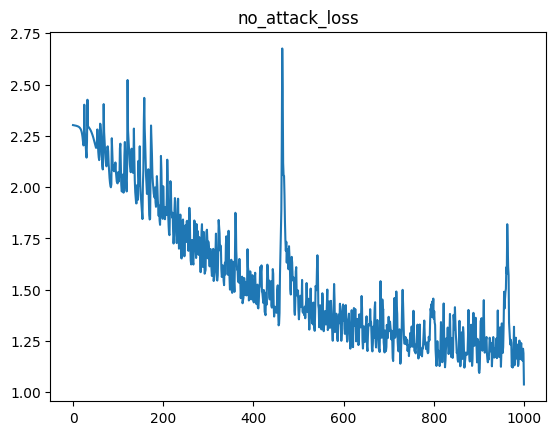

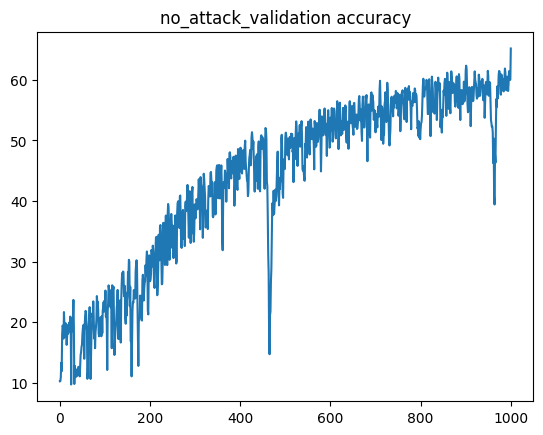

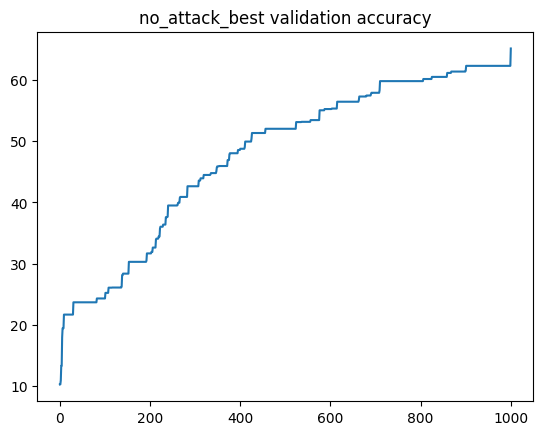

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("no_attack_"+col)
    plt.savefig('./no_attack_' + col + '.png')
    plt.show()

## Code for LIE attack, followed by its execution on Bulyan

In [ ]:
def lie_attack(all_updates, z):
    avg = torch.mean(all_updates, dim=0)
    std = torch.std(all_updates, dim=0)
    return avg + z * std

In [ ]:
batch_size=250
resume=0
nepochs=1200
schedule=[1000]
nbatches = user_tr_len//batch_size

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='lie'
z_values={3:0.69847, 5:0.7054, 8:0.71904, 10:0.72575, 12:0.73891}
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation

for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()
    r=np.arange(user_tr_len)

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    while epoch_num <= nepochs:
        user_grads=[]
        if not epoch_num and epoch_num%nbatches == 0:
            np.random.shuffle(r)
            for i in range(nusers):
                user_tr_data_tensors[i]=user_tr_data_tensors[i][r]
                user_tr_label_tensors[i]=user_tr_label_tensors[i][r]

        for i in range(n_attacker, nusers):

            inputs = user_tr_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_tr_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        if n_attacker > 0:
            n_attacker_ = max(1, n_attacker**2//nusers)
            if at_type == 'lie':
                mal_update = lie_attack(user_grads[:n_attacker], z_values[n_attacker])
            
        mal_updates = torch.stack([mal_update] * n_attacker)
        malicious_grads = torch.cat((mal_updates, user_grads), 0)

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)
            sys.exit()
            
        agg_grads, krum_candidate=bulyan(malicious_grads, n_attacker)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        if epoch_num%10==0 or epoch_num==nepochs-1:
            print('%s: at %s n_at %d n_mal_sel %d e %d fed_model val loss %.4f val acc %.4f best val_acc %f te_acc %f'%(aggregation, at_type, n_attacker, np.sum(krum_candidate < n_attacker), epoch_num, val_loss, val_acc, best_global_acc,best_global_te_acc))

        if val_loss > 10:
            print('val loss %f too high'%val_loss)
            break

        epoch_num+=1

## Code for our AGR-tailored attack on Bulyan
* Note that our attacks on multi-krum and Bulyan aggregations are the same

In [ ]:
def our_attack_mkrum(all_updates, model_re, n_attackers, dev_type='unit_vec'):

    if dev_type == 'unit_vec':
        deviation = model_re / torch.norm(model_re)
    elif dev_type == 'sign':
        deviation = torch.sign(model_re)
    elif dev_type == 'std':
        deviation = torch.std(all_updates, 0)

    lamda = torch.Tensor([3.0]).cuda()

    threshold_diff = 1e-5
    lamda_fail = lamda
    lamda_succ = 0

    while torch.abs(lamda_succ - lamda) > threshold_diff:
        mal_update = (model_re - lamda * deviation)
        mal_updates = torch.stack([mal_update] * n_attackers)
        mal_updates = torch.cat((mal_updates, all_updates), 0)

        agg_grads, krum_candidate = multi_krum(mal_updates, n_attackers, multi_k=True)
        if np.sum(krum_candidate < n_attackers) == n_attackers:
            # print('successful lamda is ', lamda)
            lamda_succ = lamda
            lamda = lamda + lamda_fail / 2
        else:
            lamda = lamda - lamda_fail / 2

        lamda_fail = lamda_fail / 2

    mal_update = (model_re - lamda_succ * deviation)
    return mal_update

## Execute our AGR-tailored attack on Bulyan

In [ ]:
batch_size=250
resume=0
nepochs=1200
schedule=[1000]
nbatches = user_tr_len//batch_size

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()
    r=np.arange(user_tr_len)

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    while epoch_num <= nepochs:
        user_grads=[]
        if not epoch_num and epoch_num%nbatches == 0:
            np.random.shuffle(r)
            for i in range(nusers):
                user_tr_data_tensors[i]=user_tr_data_tensors[i][r]
                user_tr_label_tensors[i]=user_tr_label_tensors[i][r]

        for i in range(nusers):

            inputs = user_tr_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_tr_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        if n_attacker > 0:
            n_attacker_ = max(1, n_attacker**2//nusers)
            if at_type == 'lie':
                mal_update = lie_attack(user_grads[:n_attacker], z_values[n_attacker])
            elif at_type == 'fang':
                agg_grads = torch.mean(user_grads[:n_attacker], 0)
                deviation = torch.sign(agg_grads)
                mal_update = get_malicious_updates_fang(user_grads[:n_attacker], agg_grads, deviation, n_attacker_)
            elif at_type == 'our-agr':
                agg_grads = torch.mean(user_grads[:n_attacker], 0)
                mal_update = our_attack_mkrum(user_grads[:n_attacker], agg_grads, n_attacker_, dev_type)
            elif at_type == 'min-max':
                agg_grads = torch.mean(user_grads[:n_attacker], 0)
                mal_update = our_attack_dist(user_grads[:n_attacker], agg_grads, n_attacker_, dev_type)
            elif at_type == 'min-sum':
                agg_grads = torch.mean(user_grads[:n_attacker], 0)
                mal_update = our_attack_score(user_grads[:n_attacker], agg_grads, n_attacker_, dev_type)

            mal_updates = torch.stack([mal_update] * n_attacker)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0)
            
        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)
            sys.exit()
        
        agg_grads, krum_candidate=bulyan(malicious_grads, n_attacker)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        if epoch_num%25==0 or epoch_num==nepochs-1:
            print('%s: at %s n_at %d n_mal_sel %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(aggregation, at_type, n_attacker, np.sum(krum_candidate < n_attacker), epoch_num, val_loss, val_acc, best_global_acc))

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break
            
        epoch_num+=1

## Code for our first AGR-agnostic attack called Min-Max

In [ ]:
'''
MIN-MAX attack
'''
def our_attack_dist(all_updates, model_re, n_attackers, dev_type='unit_vec'):

    if dev_type == 'unit_vec':
        deviation = model_re / torch.norm(model_re)  # unit vector, dir opp to good dir
    elif dev_type == 'sign':
        deviation = torch.sign(model_re)
    elif dev_type == 'std':
        deviation = torch.std(all_updates, 0)

    lamda = torch.Tensor([10.0]).float().cuda()
    # print(lamda)
    threshold_diff = 1e-5
    lamda_fail = lamda
    lamda_succ = 0
    
    distances = []
    for update in all_updates:
        distance = torch.norm((all_updates - update), dim=1) ** 2
        distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)
    
    max_distance = torch.max(distances)
    del distances

    while torch.abs(lamda_succ - lamda) > threshold_diff:
        mal_update = (model_re - lamda * deviation)
        distance = torch.norm((all_updates - mal_update), dim=1) ** 2
        max_d = torch.max(distance)
        
        if max_d <= max_distance:
            # print('successful lamda is ', lamda)
            lamda_succ = lamda
            lamda = lamda + lamda_fail / 2
        else:
            lamda = lamda - lamda_fail / 2

        lamda_fail = lamda_fail / 2

    mal_update = (model_re - lamda_succ * deviation)
    
    return mal_update

## Execute Min-max attack on Bulyan

In [ ]:
batch_size=250
resume=0
nepochs=1200
schedule=[1000]
nbatches = user_tr_len//batch_size

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='min-max'
dev_type ='std'
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation

for n_attacker in n_attackers:
    candidates = []

    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    torch.cuda.empty_cache()
    r=np.arange(user_tr_len)

    while epoch_num <= nepochs:
        user_grads=[]
        if not epoch_num and epoch_num%nbatches == 0:
            np.random.shuffle(r)
            for i in range(nusers):
                user_tr_data_tensors[i]=user_tr_data_tensors[i][r]
                user_tr_label_tensors[i]=user_tr_label_tensors[i][r]

        for i in range(nusers):

            inputs = user_tr_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_tr_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        if n_attacker > 0:
            n_attacker_ = max(1, n_attacker**2//nusers)
            if at_type == 'lie':
                mal_update = lie_attack(user_grads[:n_attacker], z_values[n_attacker])
            elif at_type == 'fang':
                agg_grads = torch.mean(user_grads[:n_attacker], 0)
                deviation = torch.sign(agg_grads)
                mal_update = get_malicious_updates_fang(user_grads[:n_attacker], agg_grads, deviation, n_attacker_)
            elif at_type == 'our-agr':
                agg_grads = torch.mean(user_grads[:n_attacker], 0)
                mal_update = our_attack_mkrum(user_grads[:n_attacker], agg_grads, n_attacker_, dev_type)
            elif at_type == 'min-max':
                agg_grads = torch.mean(user_grads[:n_attacker], 0)
                mal_update = our_attack_dist(user_grads[:n_attacker], agg_grads, n_attacker_, dev_type)
            elif at_type == 'min-sum':
                agg_grads = torch.mean(user_grads[:n_attacker], 0)
                mal_update = our_attack_score(user_grads[:n_attacker], agg_grads, n_attacker_, dev_type)

            mal_updates = torch.stack([mal_update] * n_attacker)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0)

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)
            sys.exit()
        
        agg_grads, krum_candidate=bulyan(malicious_grads, n_attacker)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        if epoch_num%25==0 or epoch_num==nepochs-1:
            print('%s: at %s n_at %d n_mal_sel %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(aggregation, at_type, n_attacker, np.sum(krum_candidate < n_attacker), epoch_num, val_loss, val_acc, best_global_acc))

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break
            
        epoch_num+=1

## Code for our second AGR-agnostic attack called Min-Sum

In [ ]:
'''
MIN-SUM attack
'''

def our_attack_score(all_updates, model_re, n_attackers, dev_type='unit_vec'):

    if dev_type == 'unit_vec':
        deviation = model_re / torch.norm(model_re)  # unit vector, dir opp to good dir
    elif dev_type == 'sign':
        deviation = torch.sign(model_re)
    elif dev_type == 'std':
        deviation = torch.std(all_updates, 0)
    
    lamda = torch.Tensor([10.0]).float().cuda()
    # print(lamda)
    threshold_diff = 1e-5
    lamda_fail = lamda
    lamda_succ = 0
    
    distances = []
    for update in all_updates:
        distance = torch.norm((all_updates - update), dim=1) ** 2
        distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)
    
    scores = torch.sum(distances, dim=1)
    min_score = torch.min(scores)
    del distances

    while torch.abs(lamda_succ - lamda) > threshold_diff:
        mal_update = (model_re - lamda * deviation)
        distance = torch.norm((all_updates - mal_update), dim=1) ** 2
        score = torch.sum(distance)
        
        if score <= min_score:
            # print('successful lamda is ', lamda)
            lamda_succ = lamda
            lamda = lamda + lamda_fail / 2
        else:
            lamda = lamda - lamda_fail / 2

        lamda_fail = lamda_fail / 2

    # print(lamda_succ)
    mal_update = (model_re - lamda_succ * deviation)
    
    return mal_update
    

## Execute Min-Sum attack on Bulyan

In [ ]:
batch_size=250
resume=0
nepochs=1200
schedule=[1000]
nbatches = user_tr_len//batch_size

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='min-sum'
dev_type ='std'
z=0
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation

for n_attacker in n_attackers:
    candidates = []

    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    torch.cuda.empty_cache()
    r=np.arange(user_tr_len)

    while epoch_num <= nepochs:
        user_grads=[]
        if not epoch_num and epoch_num%nbatches == 0:
            np.random.shuffle(r)
            for i in range(nusers):
                user_tr_data_tensors[i]=user_tr_data_tensors[i][r]
                user_tr_label_tensors[i]=user_tr_label_tensors[i][r]

        for i in range(nusers):

            inputs = user_tr_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_tr_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        if n_attacker > 0:
            n_attacker_ = max(1, n_attacker**2//nusers)
            if at_type == 'lie':
                mal_update = lie_attack(user_grads[:n_attacker], z_values[n_attacker])
            elif at_type == 'fang':
                agg_grads = torch.mean(user_grads[:n_attacker], 0)
                deviation = torch.sign(agg_grads)
                mal_update = get_malicious_updates_fang(user_grads[:n_attacker], agg_grads, deviation, n_attacker_)
            elif at_type == 'our-agr':
                agg_grads = torch.mean(user_grads[:n_attacker], 0)
                mal_update = our_attack_mkrum(user_grads[:n_attacker], agg_grads, n_attacker_, dev_type)
            elif at_type == 'min-max':
                agg_grads = torch.mean(user_grads[:n_attacker], 0)
                mal_update = our_attack_dist(user_grads[:n_attacker], agg_grads, n_attacker_, dev_type)
            elif at_type == 'min-sum':
                agg_grads = torch.mean(user_grads[:n_attacker], 0)
                mal_update = our_attack_score(user_grads[:n_attacker], agg_grads, n_attacker_, dev_type)

            mal_updates = torch.stack([mal_update] * n_attacker)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0)

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)
            sys.exit()
        
        agg_grads, krum_candidate=bulyan(malicious_grads, n_attacker)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        if epoch_num%25==0 or epoch_num==nepochs-1:
            print('%s: at %s n_at %d n_mal_sel %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(aggregation, at_type, n_attacker, np.sum(krum_candidate < n_attacker), epoch_num, val_loss, val_acc, best_global_acc))

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break
            
        epoch_num+=1